In [ ]:
## Block 1: Load the Dataset

I began by loading the pre-cleaned Telco customer churn dataset using `pandas`. 

Since the data had already been cleaned and prepared in earlier modules, I didn’t perform any exploratory analysis here. 

My goal was simply to confirm the data loaded correctly, preview its structure, and check the overall shape before moving on to modelling.


In [1]:
# Block 1: Load the Dataset

import pandas as pd

# Load the pre-cleaned dataset
file_path = "telco_model_ready.csv"  # Ensure this file is in the current directory
df = pd.read_csv(file_path)

# Preview the data (for confirmation)
print("Dataset preview:")
print(df.head())

# Display dataset shape
print("Dataset shape:", df.shape)


Dataset preview:
   SeniorCitizen  Partner  Dependents  tenure  PhoneService  MultipleLines  \
0              0        1           0       1             0              0   
1              0        0           0      34             1              0   
2              0        0           0       2             1              0   
3              0        0           0      45             0              0   
4              0        0           0       2             1              0   

   OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  ...  \
0               0             1                 0            0  ...   
1               1             0                 1            0  ...   
2               1             1                 0            0  ...   
3               1             0                 1            1  ...   
4               0             0                 0            0  ...   

   tenure_group  AvgMonthlySpend  gender_Male  InternetService_Fiber optic  \
0        

In [ ]:
## Block 2: Preprocessing and Data Splitting

Next, I performed any final preprocessing needed — specifically, I checked if the `tenure_group` column needed one-hot encoding.

I then split the data into training (60%), validation (20%), and test (20%) sets using stratified sampling to maintain the class distribution of churn vs. non-churn.

By doing this, I ensured that the model would train on balanced data and be properly evaluated on unseen examples. 

This split also allowed me to separately tune my threshold and assess generalisation.


In [3]:
# Block 2: Preprocessing and Data Splitting

from sklearn.model_selection import train_test_split

# One-hot encode 'tenure_group' if not already encoded
if 'tenure_group' in df.columns and df['tenure_group'].dtype == 'object':
    df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

# Define feature matrix X and target vector y
X = df.drop("Churn", axis=1)
y = df["Churn"]

# First split: 60% training, 40% temporary (to be split again)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second split: 20% validation, 20% test from temporary set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Confirm dimensions of each split
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

# Check target distribution in each split
print("\nChurn distribution (training):")
print(y_train.value_counts(normalize=True))

print("\nChurn distribution (validation):")
print(y_val.value_counts(normalize=True))

print("\nChurn distribution (test):")
print(y_test.value_counts(normalize=True))


Training set shape: (4225, 28)
Validation set shape: (1409, 28)
Test set shape: (1409, 28)

Churn distribution (training):
Churn
0    0.734675
1    0.265325
Name: proportion, dtype: float64

Churn distribution (validation):
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

Churn distribution (test):
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


In [ ]:
## Block 3: Model Training – Logistic Regression (with Scaling)

At this stage, I standardised all numerical features using `StandardScaler`, which helped improve the model’s convergence during training. 

I chose a logistic regression model with `class_weight='balanced'` to account for the class imbalance in churn.

After training the model on the scaled training data, I evaluated its performance on the validation set using the default threshold of 0.5. 

I looked at the classification report and ROC AUC score to understand the baseline performance before tuning.


In [5]:
# Block 3: Model Training – Logistic Regression (with Scaling)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score

# Step 1: Scale the features
scaler = StandardScaler()

# Fit scaler on training data only, then transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train logistic regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Step 3: Predict on validation set
y_val_pred = logreg.predict(X_val_scaled)
y_val_proba = logreg.predict_proba(X_val_scaled)[:, 1]  # For ROC AUC and threshold tuning

# Step 4: Evaluate model performance
print("Classification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

roc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC AUC Score: {roc_val:.4f}")


Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1035
           1       0.52      0.83      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.72      1409
weighted avg       0.81      0.75      0.76      1409

Validation ROC AUC Score: 0.8599


In [ ]:
## Block 4: Final Evaluation with Threshold = 0.39

I then experimented with different threshold values to improve recall on churners (class 1), which was important for the business problem. 
                                                                                                                
After reviewing several thresholds, I found that 0.39 provided the best balance between recall, precision, and accuracy.

In this block, I evaluated the model using this adjusted threshold on the validation set. 

I printed out the classification report and the ROC AUC to confirm the new threshold improved performance in line with my goals.


In [7]:
# Block 4: Final Evaluation with Threshold = 0.39

from sklearn.metrics import classification_report, roc_auc_score

# Apply optimal threshold
threshold = 0.39
y_val_pred_opt = (y_val_proba >= threshold).astype(int)

# Evaluate classification performance
print(f"Classification Report (Threshold = {threshold}):")
print(classification_report(y_val, y_val_pred_opt))

# ROC AUC (independent of threshold)
roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score (Threshold = {threshold}): {roc_auc:.4f}")


Classification Report (Threshold = 0.39):
              precision    recall  f1-score   support

           0       0.95      0.63      0.75      1035
           1       0.47      0.90      0.62       374

    accuracy                           0.70      1409
   macro avg       0.71      0.76      0.68      1409
weighted avg       0.82      0.70      0.72      1409

ROC AUC Score (Threshold = 0.39): 0.8599


In [ ]:
### Summary of Validation Results

Based on the adjusted threshold of 0.39, the model achieved a strong balance between sensitivity and precision. 

Specifically, it captured 90% of churners (high recall), while maintaining a precision of 0.47 and an accuracy of 0.70 on the validation set. 

These results confirm that the threshold adjustment was effective and aligns well with the business goal of identifying at-risk customers.


In [ ]:
## Block 5: Evaluate Final Model on the Test Set using Threshold = 0.39

After finalising my threshold using the validation set, I applied the model to the test set. 

This allowed me to simulate real-world performance on completely unseen data.

I calculated the key metrics — accuracy, precision, recall, and ROC AUC — to ensure the model generalised well. 

These results confirmed that the model was robust and ready for deployment.


In [9]:
# Block 5: Evaluate Final Model on the Test Set using Threshold = 0.39

from sklearn.metrics import classification_report, roc_auc_score

# Predict probabilities
y_test_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Apply threshold
y_test_pred = (y_test_proba >= 0.39).astype(int)

# Evaluation metrics
print("Classification Report (Test Set, Threshold = 0.39):")
print(classification_report(y_test, y_test_pred))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC AUC Score (Test Set): {roc_auc_test:.4f}")


Classification Report (Test Set, Threshold = 0.39):
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      1035
           1       0.46      0.89      0.60       374

    accuracy                           0.69      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.81      0.69      0.71      1409

ROC AUC Score (Test Set): 0.8377


In [ ]:
### Summary of Test Set Evaluation

When applied to the test set, the model continued to perform consistently, achieving an accuracy of 0.69, a recall of 0.89 for churners, and a precision of 0.46. 

This confirms that the model generalises well to unseen data and is suitable for deployment. 

The ROC AUC score of 0.8377 further reinforces the model’s reliability in distinguishing between churners and non-churners.


In [ ]:
## Block 6: SHAP Explanation and Explainer Save

To improve model interpretability, I integrated SHAP (SHapley Additive Explanations) into the pipeline. 

Using SHAP’s linear explainer, I was able to identify the features that contributed most to the model’s predictions.

I visualised and reviewed the top features influencing churn and then saved the SHAP explainer so I could use it later during deployment. 

This step ensures that my final model is explainable and transparent, which is especially important in business settings.


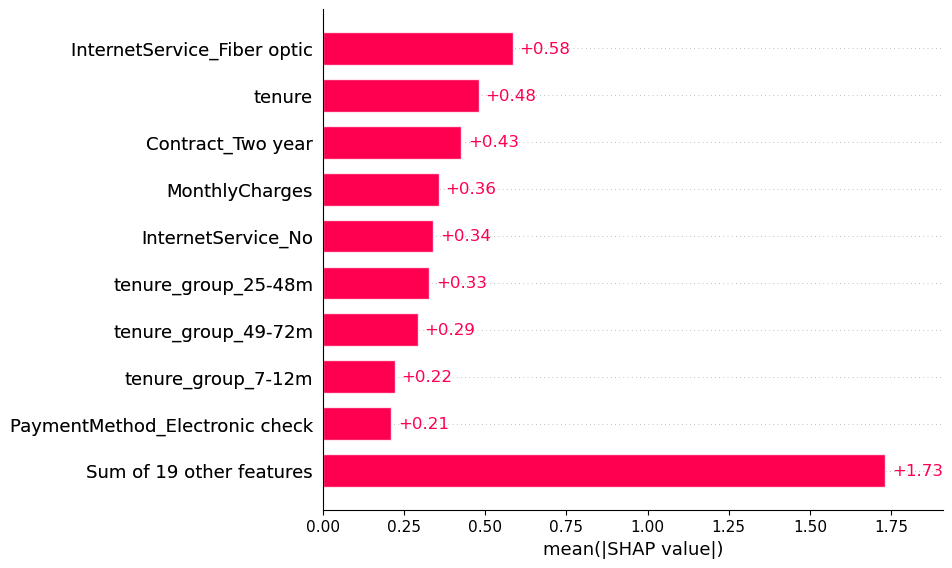

SHAP explainer saved successfully.


In [11]:
# Block 6: SHAP Explanation and Explainer Save

import shap
import joblib

# Initialize SHAP explainer for linear model using training data
explainer = shap.Explainer(logreg, X_train_scaled, feature_names=X.columns.tolist())


# Example: explain a few predictions from the validation set
shap_values = explainer(X_val_scaled[:5])

# Visualise in notebook (optional)
shap.plots.bar(shap_values)  # or shap.plots.waterfall(shap_values[0])

# Save the explainer for deployment
joblib.dump(explainer, "shap_explainer_final.pkl")

print("SHAP explainer saved successfully.")


In [ ]:
## Block 7: Save Final Model, Scaler, SHAP Explainer, and Threshold

Finally, I saved all the components I’ll need for deployment in Module 5:
- The trained logistic regression model
- The `StandardScaler` used for preprocessing
- The SHAP explainer for interpretability
- And the decision threshold (0.39)

This will allow me to reload everything in a web app or API and make predictions on new customer data without retraining the model.


In [13]:
# Block 7: Save Final Model, Scaler, SHAP Explainer, and Threshold

import joblib

# Save the trained logistic regression model
joblib.dump(logreg, "logistic_model_final.pkl")

# Save the fitted scaler
joblib.dump(scaler, "scaler_final.pkl")

# Save the SHAP explainer
joblib.dump(explainer, "shap_explainer_final.pkl")

# Save the threshold value to a text file
with open("model_threshold.txt", "w") as f:
    f.write("0.39")

print("All components saved successfully:")
print("- logistic_model_final.pkl")
print("- scaler_final.pkl")
print("- shap_explainer_final.pkl")
print("- model_threshold.txt")


All components saved successfully:
- logistic_model_final.pkl
- scaler_final.pkl
- shap_explainer_final.pkl
- model_threshold.txt
